# Multitask - the OxfordIIITPet dataset for segmentation and classification

In [15]:
from PIL import Image

In [16]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Dataset
import timm
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [17]:
class MultiTaskDataset(Dataset):
    def __init__(self, split, common_transforms, image_transforms, mask_transforms):
        self.data = OxfordIIITPet(
            root="../data",
            download=True,
            split=split,
            target_types=("category", "segmentation"),
        )
        # Important! We also use a random data augmentation! we need to apply the same transformation to the image and the segmentation mak
        self.common_transforms = common_transforms
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image, (class_label, segmentation_mask) = self.data[i]
        image = v2.functional.to_image(image)
        segmentation_mask = v2.functional.to_image(segmentation_mask) - 1

        # # This is wrong
        # image = self.common_transforms(image)
        # segmentation_mask = self.common_transforms(segmentation_mask)
        # # If we do this, we might flip the image, but not flip the segmentation mask!!!
        # # We need to flip both, or flip none

        image_and_mask = torch.cat([image, segmentation_mask])
        # We concatenate the image and the segmentation mask and perform data augmentation on both, treating the segmentation mask as a 4th channel.
        image_and_mask = self.common_transforms(image_and_mask)
        image = self.image_transforms(image_and_mask[:3])
        segmentation_mask = self.mask_transforms(image_and_mask[3:])

        return image, class_label, segmentation_mask

In [18]:
common_transforms_train = v2.Compose([
    v2.Resize([224, 224]),
    v2.RandomHorizontalFlip(p=0.5),
])
image_transforms_train = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.ColorJitter(contrast=0.3),
])
mask_transforms_train = v2.Compose([
    v2.ToDtype(torch.long),
])

common_transforms_test = v2.Compose([
    v2.Resize([224, 224]),
])
image_transforms_test = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])
mask_transforms_test = mask_transforms_train

train_dataset = MultiTaskDataset("trainval", common_transforms_train, image_transforms_train, mask_transforms_train)
test_dataset = MultiTaskDataset("test", common_transforms_test, image_transforms_test, mask_transforms_test)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64, drop_last=False)

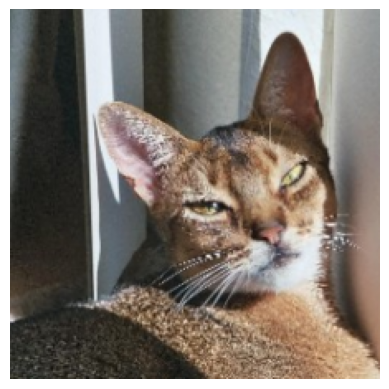

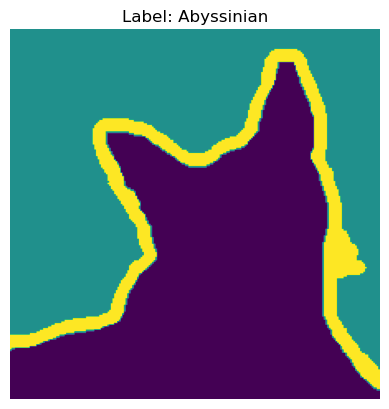

In [19]:
first_image, first_label, first_mask = test_dataset[12]
plt.imshow(first_image.permute(1, 2, 0))
plt.axis("off")
plt.show()
plt.title(f"Label: {test_dataset.data.classes[first_label]}")
plt.imshow(first_mask.squeeze(0))
plt.axis("off")
plt.show()

In [20]:
for images, labels, masks in train_loader:
    break
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 1, 224, 224])


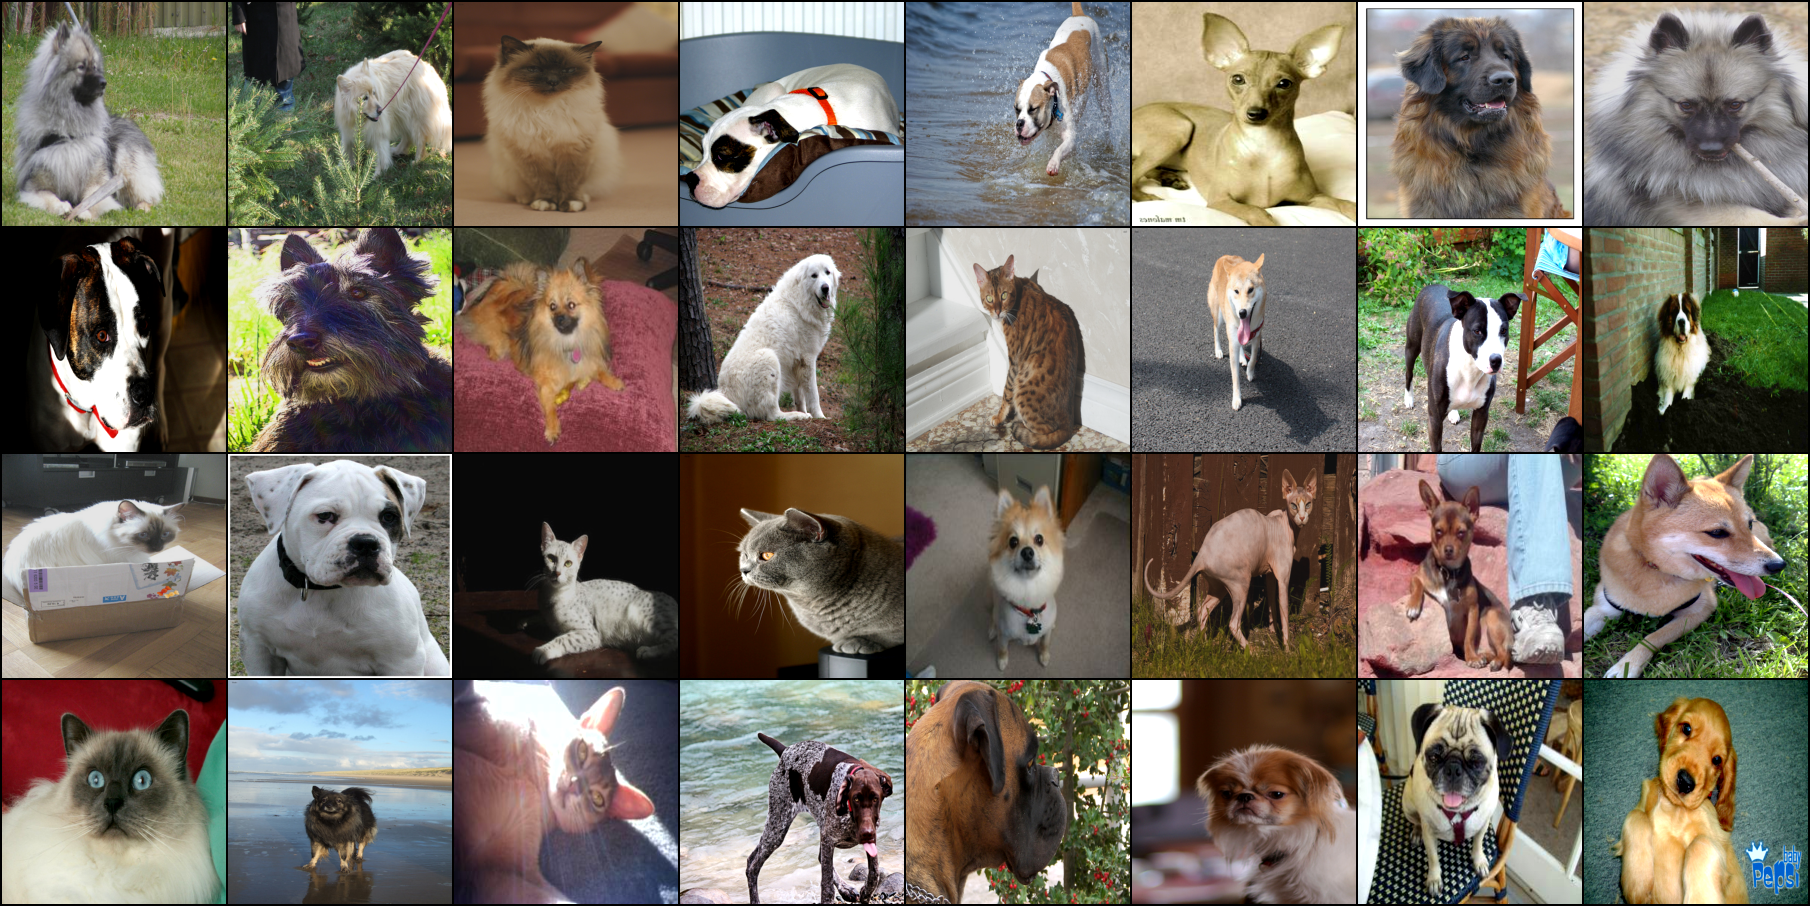

In [21]:
v2.functional.to_pil_image(torchvision.utils.make_grid(images, nrow=8))

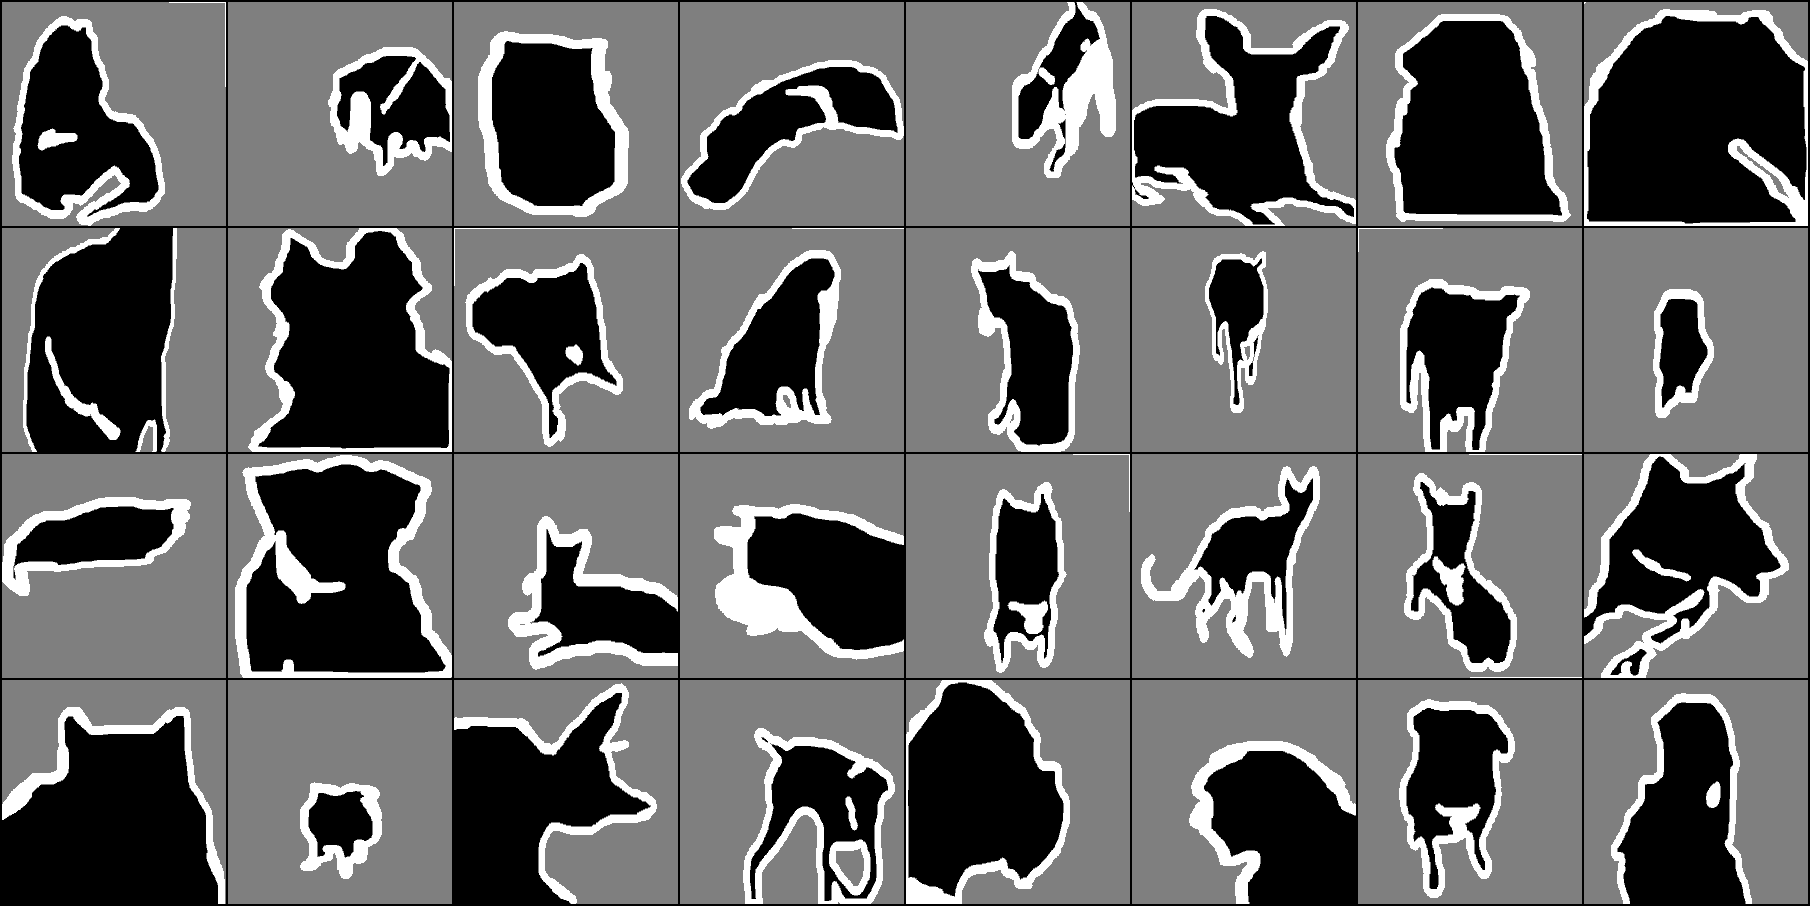

In [22]:
v2.functional.to_pil_image(torchvision.utils.make_grid(masks / 2.0, nrow=8))

In [23]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone_name='resnet18', num_classes=37, num_segmentation_classes=3):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, features_only=True)
        out_channels = self.backbone.feature_info[-1]['num_chs']

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels * 7 * 7, num_classes)
        )

        self.segmentation_head = nn.Sequential(
            nn.Conv2d(out_channels, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_segmentation_classes, kernel_size=1),
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        )

    def forward(self, x):
        features = self.backbone(x)[-1]
        class_logits = self.classifier(features)
        seg_logits = self.segmentation_head(features)
        return class_logits, seg_logits


In [24]:
def f1_score(predicted, target):
    tp = (predicted & target).sum().item()
    fp = (predicted & ~target).sum().item()
    fn = (~predicted & target).sum().item()
    return 2 * tp / (2 * tp + fp + fn + 1e-8)


def f1_macro(predicted, targets, num_classes):
    f1s = []
    for cls in range(num_classes):
        f1s.append(f1_score(predicted == cls, targets == cls))
    return sum(f1s) / num_classes


def iou_score(pred, target):
    intersection = (pred & target).sum().item()
    union = (pred | target).sum().item()
    return intersection / (union + 1e-8)


def iou_macro(preds, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        ious.append(iou_score(preds == cls, targets == cls))
    return sum(ious) / num_classes

In [25]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        targets_onehot = torch.nn.functional.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = (preds * targets_onehot).sum(dims)
        union = preds.sum(dims) + targets_onehot.sum(dims)
        dice = (2 * intersection + 1e-8) / (union + 1e-8)
        return 1 - dice.mean()


class IoULoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, logits, targets):
        probs = torch.nn.functional.softmax(logits, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, self.num_classes)
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()

        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = (probs + targets_one_hot - probs * targets_one_hot).sum(dim=(2, 3))
        iou = (intersection + 1e-8) / (union + 1e-8)
        return 1 - iou.mean()


class DicePlusCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.ce(preds, targets)


class DicePlusIoULoss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.dice = DiceLoss()
        self.iou = IoULoss(num_classes)

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.iou(preds, targets)

In [26]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device("cpu")
print("Using device", device)
model = MultiTaskModel().to(device)
# model = MultiTaskModel("hf_hub:timm/resnest14d.gluon_in1k").to(device)
classification_criterion = nn.CrossEntropyLoss()
# segmentation_criterion = DicePlusCELoss()
# segmentation_criterion = DiceLoss()
segmentation_criterion = DicePlusIoULoss(3)
# segmentation_criterion = IoULoss(3)
classification_factor = 0.2
segmentation_factor = 0.8
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

Using device cuda


In [27]:
def train():
    cls_f1_sum = 0.0
    seg_dice_sum = 0.0
    seg_iou_sum = 0.0
    num_batches = 0

    model.train()
    for images, class_labels, segmentation_masks in tqdm(train_loader, desc="Training"):
        images = images.to(device)
        class_labels = class_labels.to(device)
        segmentation_masks = segmentation_masks.to(device)
        with torch.autocast(device.type, enabled=device.type == 'cuda'):
            class_logits, seg_logits = model(images)
            loss_cls = classification_criterion(class_logits, class_labels) * classification_factor
            loss_seg = segmentation_criterion(seg_logits, segmentation_masks.squeeze(1)) * segmentation_factor
            loss = loss_cls + loss_seg

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            cls_f1 = f1_macro(class_logits.argmax(1), class_labels, num_classes=37)
            seg_dice = f1_macro(seg_logits.argmax(1), segmentation_masks, num_classes=3)
            seg_iou = iou_macro(seg_logits.argmax(1), segmentation_masks, num_classes=3)

        cls_f1_sum += cls_f1
        seg_dice_sum += seg_dice
        seg_iou_sum += seg_iou
        num_batches += 1

    return cls_f1_sum / num_batches, seg_dice_sum / num_batches, seg_iou_sum / num_batches


@torch.inference_mode()
def val():
    cls_f1_sum = 0.0
    seg_dice_sum = 0.0
    seg_iou_sum = 0.0
    num_batches = 0

    model.eval()
    for images, class_labels, segmentation_masks in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        class_labels = class_labels.to(device)
        segmentation_masks = segmentation_masks.to(device)

        with torch.autocast(device.type, enabled=device.type == 'cuda'):
            class_logits, seg_logits = model(images)
            cls_f1 = f1_macro(class_logits.argmax(dim=1), class_labels, num_classes=37)
            seg_dice = f1_macro(seg_logits.argmax(dim=1), segmentation_masks, num_classes=3)
            seg_iou = iou_macro(seg_logits.argmax(1), segmentation_masks, num_classes=3)

        cls_f1_sum += cls_f1
        seg_dice_sum += seg_dice
        seg_iou_sum += seg_iou
        num_batches += 1

    return cls_f1_sum / num_batches, seg_dice_sum / num_batches, seg_iou_sum / num_batches

In [ ]:
num_epochs = 10
model.backbone.requires_grad_(False)
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    if epoch == 3:
        model.backbone.requires_grad_(True)
    tr_f1, tr_dice, tr_iou = train()
    vl_f1, vl_dice, vl_iou = val()
    print(f"[Train] F1: {tr_f1:.4f} | Dice: {tr_dice:.4f} | IoU: {tr_iou:.4f}")
    print(f"[Val]   F1: {vl_f1:.4f} | Dice: {vl_dice:.4f} | IoU: {vl_iou:.4f}")


Epoch 1/10


Evaluating: 100%|██████████| 58/58 [01:34<00:00,  1.63s/it]


[Train] F1: 0.3323 | Dice: 0.4470 | IoU: 0.3222
[Val]   F1: 0.0343 | Dice: 0.4672 | IoU: 0.3333

Epoch 2/10


Evaluating: 100%|██████████| 58/58 [01:22<00:00,  1.43s/it]


[Train] F1: 0.5094 | Dice: 0.4640 | IoU: 0.3312
[Val]   F1: 0.0363 | Dice: 0.4639 | IoU: 0.3301

Epoch 3/10


Evaluating: 100%|██████████| 58/58 [01:26<00:00,  1.50s/it]


[Train] F1: 0.5385 | Dice: 0.4625 | IoU: 0.3300
[Val]   F1: 0.0358 | Dice: 0.4624 | IoU: 0.3283

Epoch 4/10


Training:   6%|▌         | 7/115 [00:05<01:22,  1.31it/s]

In [ ]:
@torch.inference_mode()
def val_tta():
    cls_f1_sum = 0.0
    seg_dice_sum = 0.0
    seg_iou_sum = 0.0
    num_batches = 0

    model.eval()
    for images, class_labels, segmentation_masks in tqdm(test_loader, desc="Evaluating with TTA"):
        images = images.to(device)
        class_labels = class_labels.to(device)
        segmentation_masks = segmentation_masks.to(device)

        with torch.autocast(device.type, enabled=device.type == 'cuda'):
            class_logits_orig, seg_logits_orig = model(images)

        images_flipped = torch.flip(images, dims=[3])
        with torch.autocast(device.type, enabled=device.type == 'cuda'):
            class_logits_flip, seg_logits_flip = model(images_flipped)

        seg_logits_flip = torch.flip(seg_logits_flip, dims=[3])
        class_logits_avg = (class_logits_orig + class_logits_flip) / 2
        seg_logits_avg = (seg_logits_orig + seg_logits_flip) / 2
        cls_preds = class_logits_avg.argmax(dim=1)
        seg_preds = seg_logits_avg.argmax(dim=1)

        cls_f1 = f1_macro(cls_preds, class_labels, num_classes=37)
        seg_dice = f1_macro(seg_preds, segmentation_masks, num_classes=3)
        seg_iou = iou_macro(seg_preds, segmentation_masks, num_classes=3)

        cls_f1_sum += cls_f1
        seg_dice_sum += seg_dice
        seg_iou_sum += seg_iou
        num_batches += 1

    return cls_f1_sum / num_batches, seg_dice_sum / num_batches, seg_iou_sum / num_batches


vl_f1_tta, vl_dice_tta, vl_iou_tta = val_tta()
print(f"[Val TTA] F1: {vl_f1_tta:.4f} | Dice: {vl_dice_tta:.4f} | IoU: {vl_iou_tta:.4f}")